In [4]:
import math 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
def f(x):
     return 3*x**2 - 4*x + 5

In [6]:
f(3.0)

20.0

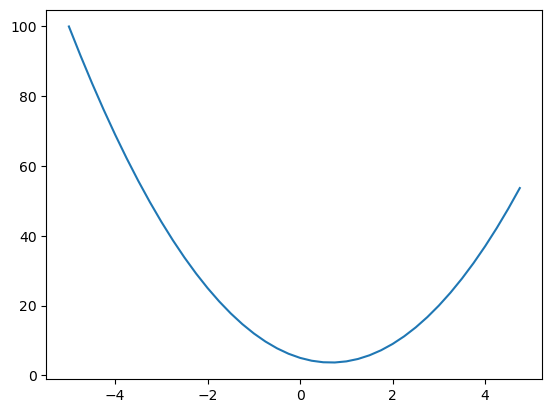

In [7]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [8]:
# Derivative
h = 0.0001
x = 3.0
(f(x + h) - f(x))/h

14.000300000063248

In [9]:
# More complex Example
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [10]:
# Derivatives of d with respect to a,b, and c
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b +  c
a += h # Slightly increasing the value of a
d2 = a*b +  c

print("d1:", d1)
print("d2:", d2)
print("slope:", (d2-d1)/h) # The rate at which 'd' will increase/decrease as we scale 'a'.


d1: 4.0
d2: 3.999699999999999
slope: -3.000000000010772


In [11]:
class Value:
    def __init__(self,data, _children=(), _op='', label=''): # _children is tuple for convenience
        self.data = data
        self.grad = 0.0 # The deviative of L with respect to the value
        self._backward = lambda: None
        self._prev = set(_children) #Maybe for efficiency, or for removing duplicates.
        self._op = _op
        self.label = label

    def __repr__(self): # String Representation
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')


        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __sub__(self, other):
            return self + (-other)

    def __mul__(self, other):  
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad 
        out._backward = _backward

        return out

    def __rmul__(self, other):
        return self * other

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward 
            
        return out
    
    def __radd__(self, other):
        return self + other
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad +=  out.data * out.grad 
        out._backward = _backward

        return out
    
    def __truediv__(self, other):
        return self * other**-1

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')
        def _backward():
            self.grad += other * (self.data ** (other - 1)) *  out.grad 
        out._backward = _backward

        return out


    def backward(self):
        topo = [] # output
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)       

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

            

# We need a expression graph, so we need to keep pointer to 
# which value produces which other values
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
# (a.__mul__(b)).__add__(c) 
d = e + c; d.label='d'
f = Value(-2.0, label='f')
L = d * f; L.label="L"
L
    

Value(data=-8.0)

In [12]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

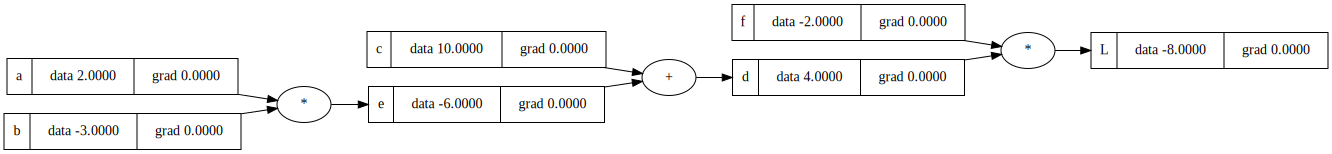

In [13]:
draw_dot(L)

In [ ]:
# Optimization, after figuring out the gradient
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad


# Rerun the forward pass
e = a*b
d = e + c
L = d * f

print(L.data)

-8.0


In [15]:
L.grad = 1.0

In [16]:
# dL/dd = d(f*d)/dd = f & dl/df = d(f*d)/df = d
f.grad = 4.0
d.grad = -2.0

In [17]:
# dL/dc = (dL/dd) * (dd/dc)
# d = c + e 
# dd/dc = 1.0
c.grad = 1.0 * -2.0 
# dL/de = (dL/dd) * (dd/de)
#dd/de = 1.0
e.grad = 1.0 * -2.0
# Here, we can think of the (+) operation as just routing the gradient 



In [18]:
# dL/da = dL/de * de/da
# dL/db = dL/de * de/db
# e = a * b
# de/da = b & de/db = a

a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0


In [19]:
# Function for testing the derivatives
def lol():
    h = 0.000001
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    # (a.__mul__(b)).__add__(c) 
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d * f; L.label="L"
    L1 = L.data

    a = Value(2.0, label='a')
    a.data += h
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    # (a.__mul__(b)).__add__(c) 
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d * f; L.label="L"
    L2 = L.data
    
    print((L2-L1)/h)

lol()



6.000000000838668


In [20]:
# Backpropagating a neuron

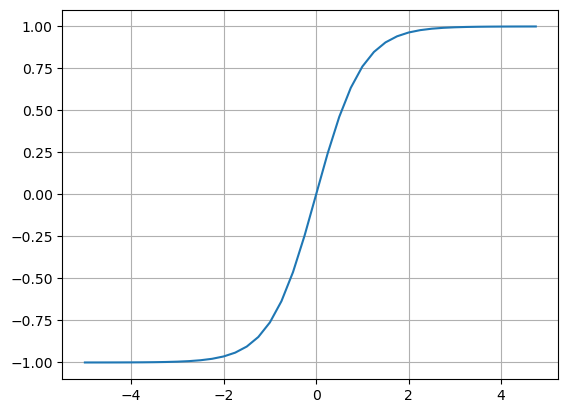

In [21]:
# tanh activation function
plt.plot(np.arange(-5, 5, 0.25), np.tanh(np.arange(-5,5, 0.25)))
plt.grid()


In [22]:
# Inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# Weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# Bias
b = Value(6.8813735870195432, label='b')
#x1*w1 + x2w2 +  b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label="x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label="o"

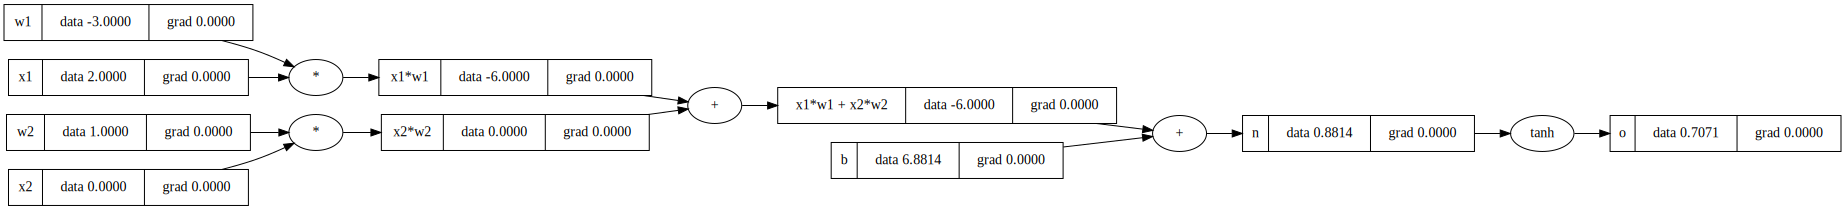

In [23]:
draw_dot(o)

In [24]:
# Manual Backpropagation
o.grad = 1.0
# o = tanh(n)
# do/dn = 1 - tanh(n)**2 
n.grad = 1 - o.data**2
x1w1x2w2.grad = 0.5
b.grad = 0.5
###
x2w2.grad = 0.5
x1w1.grad = 0.5
###
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad


In [25]:
# Reset the Gradients
### Auto Backpropagation

# Inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# Weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# Bias
b = Value(6.8813735870195432, label='b')
#x1*w1 + x2w2 +  b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label="x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label="o"

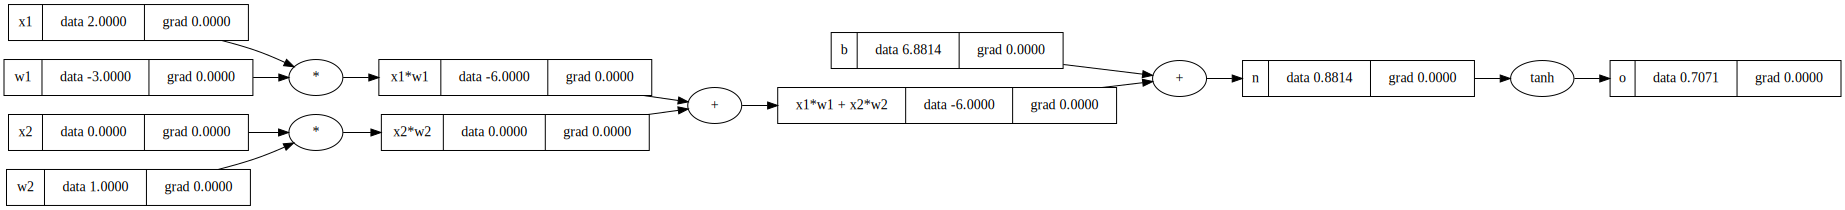

In [26]:
draw_dot(o)


In [27]:
# Manual Backpropagation with _backward()
o.grad = 1.0

In [28]:
o._backward()
    

In [29]:
n._backward()

In [30]:
x1w1x2w2._backward()

In [31]:
x1w1._backward()
x2w2._backward()

In [32]:
# Building a Topological sort for auto Backpropagation
# Topological order is a layout of a graph such that all the edges from left to right

topo = [] # output
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

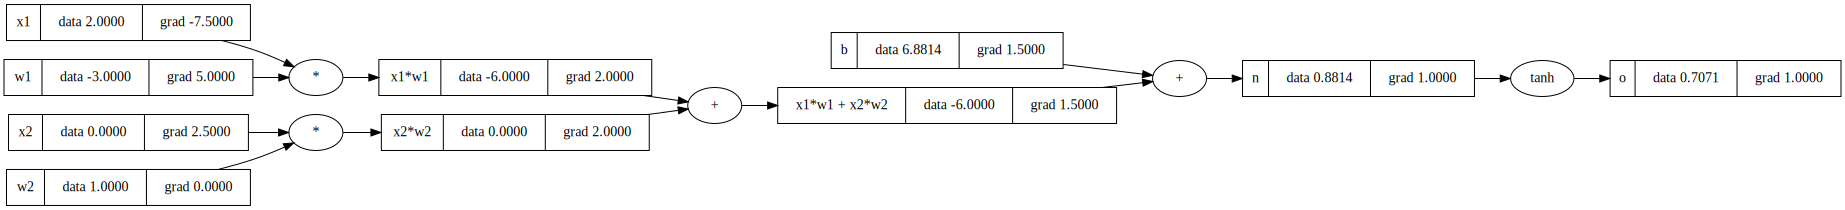

In [33]:
# Implementing the Topological order for auto backpropagation
o.grad = 1.0

for node in reversed(topo):
    node._backward()

draw_dot(o)

In [34]:
# Reset the Gradients and implementing the backward() function
### Auto Backpropagation

# Inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# Weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# Bias
b = Value(6.8813735870195432, label='b')
#x1*w1 + x2w2 +  b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label="x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label="o"


o.backward()

In [35]:
# Building a NN
import random

class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh() # Improvement
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]
  
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)


  

Value(data=-0.6571593922734509)

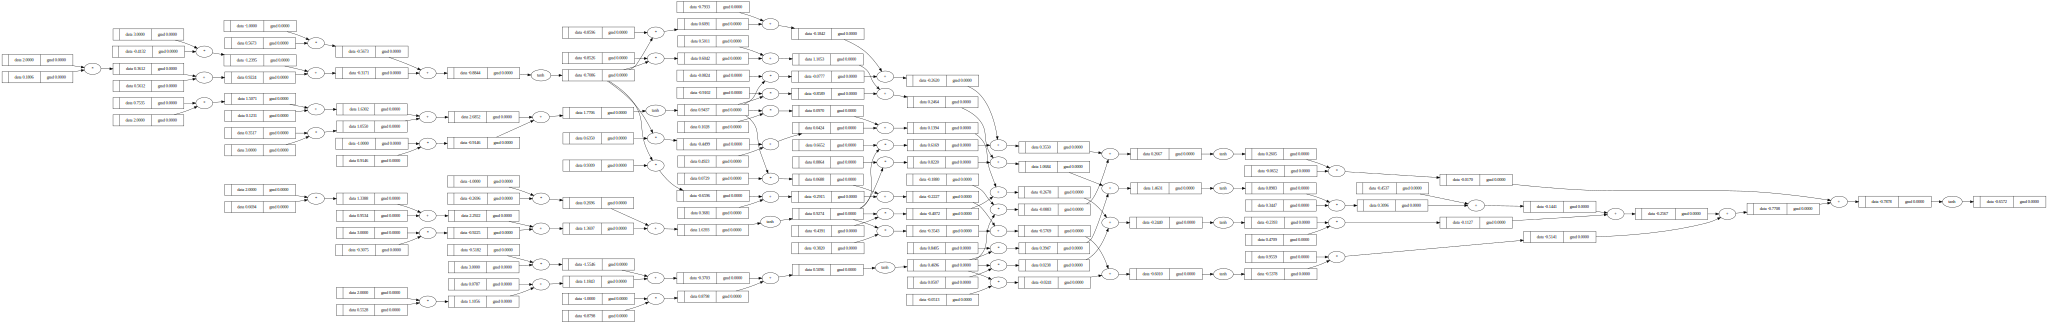

In [36]:
draw_dot(n(x))

In [37]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [38]:
for k in range(100):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)

0 8.738532060786188
1 3.340220297507676
2 3.2153256796667025
3 2.9257262447673518
4 3.725116192725485
5 1.2748445855626545
6 0.8941889717273952
7 0.29413948549132085
8 0.10836970540896988
9 0.09136224515859459
10 0.07898921541103086
11 0.06956590408322066
12 0.062141206136966394
13 0.056135720230653434
14 0.05117555132351702
15 0.04700824240049012
16 0.04345697821824811
17 0.04039412135961397
18 0.037725164121329154
19 0.03537859733824651
20 0.03329929279913832
21 0.031444052273137346
22 0.029778536670216765
23 0.028275099590187924
24 0.026911228446457103
25 0.02566840287140942
26 0.024531245414175215
27 0.023486880637815517
28 0.02252444519857857
29 0.021634708910700285
30 0.02080977848476276
31 0.02004286360267723
32 0.019328090523171672
33 0.018660352304011234
34 0.018035187503724338
35 0.017448681231115867
36 0.0168973838763328
37 0.016378243939725732
38 0.015888552182408464
39 0.015425894930718383
40 0.014988114828988479
41 0.014573277689156252
42 0.014179644359164464
43 0.0138056

In [39]:
ypred = [n(x) for x in xs]
ypred

[Value(data=0.9647845501171428),
 Value(data=-0.9546901100092645),
 Value(data=-0.9784255369564038),
 Value(data=0.9608412945457835)]